<a href="https://colab.research.google.com/github/Blacksmith1111/MIMO/blob/main/HT1v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ModulationPy

In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import PSKModem, QAMModem

from tqdm.notebook import tqdm, trange
from numpy import sqrt
plt.rcParams.update({'font.size': 15})

USE_GOOGLE_DRIVE = True
FOLDER_PATH = '/content'  #  <<< Set your value here

# Which channel file you'd like to load
CHAN_NAME = 'link_chan_{}.mat'.format('2')                                  #  <<< Set your value here

#if USE_GOOGLE_DRIVE:
 #   from google.colab import drive
  #  drive.mount('/gdrive')
   # CHAN_NAME = 'link_chan_{}.mat'.format('2')

os.chdir(FOLDER_PATH)

Number of user antennas:  4
Number of base station antennas:  64
Number of subcarriers:  256
Number of time moments:  100


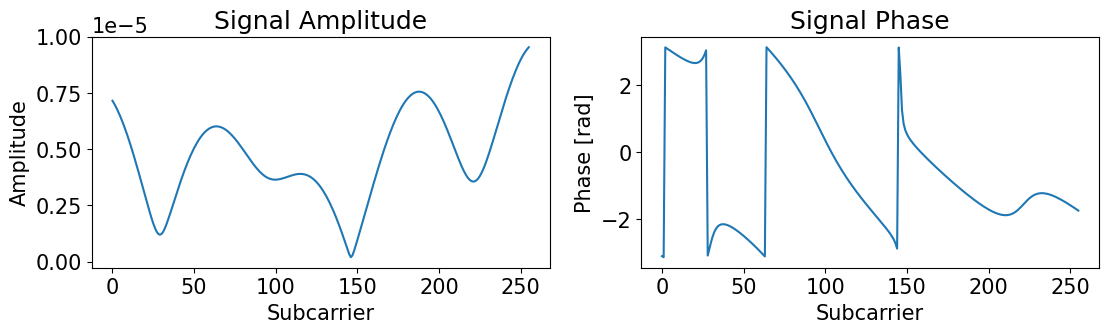

In [3]:
H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape

# Some info about signal
print('Number of user antennas: ', N_ue_ants )
print('Number of base station antennas: ', N_bs_ants)
print('Number of subcarriers: ', N_subcarriers)
print('Number of time moments: ', N_tti)

# Let's plot Amplitudes and Phases over frequencies for fixed pair of antennas
# and fixed time moment (TTI)
plt.figure(figsize = (13,3))
plt.subplot(1,2,1)
plt.plot(np.abs(H[0,0,:,0]))
plt.title('Signal Amplitude'); plt.xlabel('Subcarrier'); plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(np.angle(H[0,0,:,0]))
plt.title('Signal Phase'); plt.xlabel('Subcarrier'); plt.ylabel('Phase [rad]')
plt.show()

In [4]:
def bit_error_rate(received_bits, true_bits):
    '''Calculates bit error rate (BER) between two-bit sequences'''

    return np.mean(np.abs(received_bits - true_bits), axis = 1)


def get_noise(signal, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))

    # Calculate mean @signal power
    P_signal = np.mean(np.abs(signal)**2)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed

In [5]:
def normalize(H):
    '''
    Normalizes the channel along UE antennas and subcarriers to have unit power on each receive antenna.
    '''
    # Shape of H
    N_ue, N_bs, N_f, N_tti = H.shape

    # Calculate norms along 0,2 axis (N_ue, N_f)
    norma = np.linalg.norm(H, ord = 'fro', axis = (0,2), keepdims = True)

    # return normalized channel
    H_normed = H / norma * sqrt(N_ue)
    return H_normed

In [6]:
bits = np.random.binomial(n = 1, p = 0.5, size = N_subcarriers)
print(bits)

[0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1
 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1]


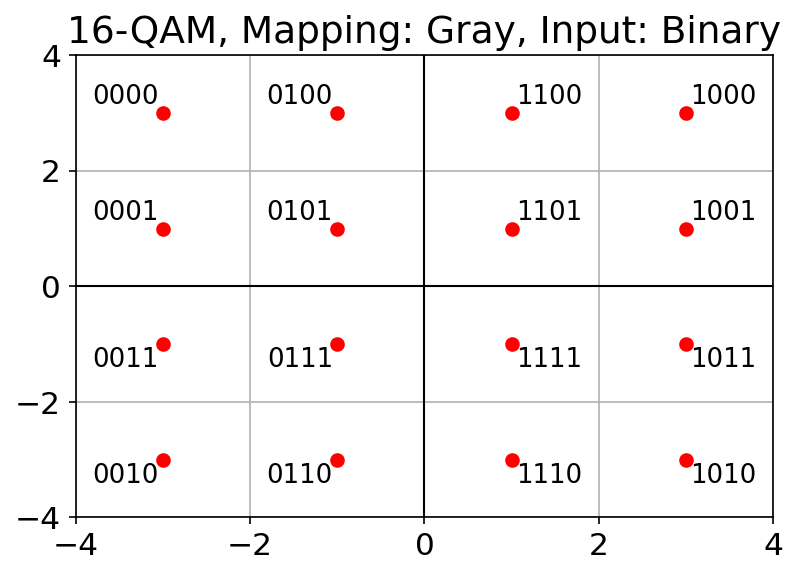

In [7]:
N_constellation_points = 16 # 16QAM modulation

# How many bits we can send using defined number of constellation points
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
                 bin_input = True,              # it will use bits as input
                 gray_map = True,               # reorder constellation points to have unit distance between neigbours
                 soft_decision = False,         # hard detector for detection
                 bin_output = True)             # demodulate signal to bits
modem.plot_const()

In [8]:
# For each subcarrier transform N_bits_per_conts_point bits into one QAM symbol
#bit_streams = 2 # added a number of bit streams
bits = np.random.binomial(n = 1, p = 0.5, size = (N_subcarriers, N_bits_per_conts_point))
#print(bits.shape)
# Normalization constant. Dont forget to denormalize signal before decoding!
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

#bitstr_num = 2 # added bit streams number myself
# Create 1 OFDM symbol with N_subcarriers QAM symbols.
qam_symbols = modem.modulate(bits.flatten()).reshape(N_subcarriers) / constellation_norm

# Print some symbols and check the normalization
print('S size: ',qam_symbols.shape, end = '\n\n')
print('Some symbols : ',qam_symbols[:15], end = '\n\n')
print('Expectation is', np.mean(np.abs(qam_symbols)**2))

S size:  (256,)

Some symbols :  [-0.31622777-0.31622777j  0.31622777-0.9486833j  -0.31622777+0.9486833j
  0.9486833 +0.9486833j  -0.31622777+0.9486833j  -0.31622777+0.9486833j
 -0.9486833 -0.31622777j -0.9486833 +0.31622777j  0.31622777+0.31622777j
 -0.9486833 +0.9486833j   0.31622777+0.31622777j -0.31622777-0.9486833j
 -0.9486833 -0.31622777j -0.31622777+0.9486833j   0.31622777+0.31622777j]

Expectation is 0.9375


In [9]:
def get_precoder(H, rank, precoder_type = 'uniform'):
	'''
	Calculates precoder with given parameters
	Inputs:
		- H (np.ndarray) is channel matrix with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
		- rank (int) is number of bit-stereams which we want to precode
		- precoder_type (str) : flag, which precoder type to use
		  if precoder_type='uniform' precoder is normalized unit vector (baseline)
		  if precoder_Type='svd' uses Vh singular vectors as precoder (SHOULD BE IMPLEMENTED)
	Returns:
		- precoder (np.ndarray) with shape of [N_bs_ants x rank x N_subcarriers]
	'''

	N_ue, N_bs, N_f = H.shape

	precoder = np.zeros((N_bs, rank, N_f), dtype = np.complex128)

	# here we calculate SVD precoder. Your task to implement it
	if precoder_type == 'svd':
		# ---------------------------------------------------------------------------------------

		for subc in range(N_f):
			left, singul, right = np.linalg.svd(H[:, :, subc])
			right_transposed = np.transpose(right)
			right_processed = np.conj(right_transposed)
			ness_vectors = right_processed[:, 0 : rank]
			precoder[:, :, subc] = ness_vectors

		# ---------------------------------------------------------------------------------------
	# here we calculate uniform precoder
	elif precoder_type == 'uniform':
		assert rank == 1  # impossible to use other ranks

		# for each subcarrier
		for subc in range(N_f):
			# precoder norm must be 1
			precoder[..., subc] = np.ones((N_bs, rank)) / (np.sqrt(N_bs * rank));


	return precoder


In [10]:
# Precoder testing

# Fix channel for some time moment
t = 0
Ht = H[..., t]

# Calculate precoder
precoder = get_precoder(H = Ht, rank = 1, precoder_type = 'uniform')
test =  get_precoder(H = Ht, rank = 2, precoder_type = 'svd')
print(test.shape)

print('precoder shape: ', precoder.shape)
print('precoder power per subcarrier: ', np.sum(np.abs(precoder)**2)/N_subcarriers)

(64, 2, 256)
precoder shape:  (64, 1, 256)
precoder power per subcarrier:  1.0


In [11]:
def transmitter_signal(s_signal, precoder):
	'''
	Forms transmitter signal using modulated data and precoder
	Inputs:
		- s_signal: (np.ndarray) streams of modulated symbols with shape of [rank x N_subcarriers] (added [rank x 1 x N_subcarriers])
		- precoder: (np.ndarray) precoder with shape of [N_bs_ants x rank x N_subcarrires]
	Output:
		- X: (np.ndarray) transmitted precoded signal with shape of [N_bs_ants x N_subcarriers]
	'''

	N_bs, rank, N_f = precoder.shape

	if len(s_signal.shape) < 3:
		s_signal = np.expand_dims(s_signal, axis = 1)
	X = np.zeros((N_bs, N_f), dtype = np.complex128)
	X = np.expand_dims(X, axis = 1)

# calculate independently for each subcarrier
# ---------------------------------------------------------------------------------------
	for subc in range(N_f):
		X[:, :, subc] = precoder[:,:,subc].dot(s_signal[:, :, subc])
# ---------------------------------------------------------------------------------------
	X = np.squeeze(X, axis = 1)

	return X

In [12]:
def receiver_signal(H, X, SNR_dB):
	'''
	Model signal at the receiver side. Returns received signal with noise is SNR_dB is int.
	If SNR_dB is None - returns ideal signal
	INPUTS:
		- H (np.ndarray): channel tensor with shape of [N_ue_ants x N_bs_ants x N_subcarrier]
		- X (np.ndarray): transmitted signal matrix with shape of [N_bs_ants x N_subcarrier]
		- SNR_dB (int or None): Signal to Noise ratio in decibels.

	'''
	N_ue, N_bs, N_f = H.shape

	if len(X.shape) == 2:
		X = np.expand_dims(X, axis = 1)

	y = np.zeros((N_ue, N_f), dtype = np.complex128)
	y = np.expand_dims(y, axis = 1)
	#print(len(X.shape), "X.shape len that is", y[:, 0].shape, H[:, :, 0].shape, X[:, 0].shape)
	# ---------------------------------------------------------------------------------------
	for subc in range(N_f):
		y[:, :, subc] = H[:, :, subc].dot(X[:, :,  subc])
	# ---------------------------------------------------------------------------------------


	N = get_noise(np.mean(H, 1) * sqrt(N_bs), SNR_dB)
	y = np.squeeze(y, axis = 1)
	return y + N

In [13]:
def effective_channel(H, P):
	'''
	Calculates effective channel with shape of [N_ue_ants x rank x N_subcarriers].
	INPUTS:
		- H: channel matrix with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
		- P: channel precoders with shape of [N_bs_ants x rank x N_subcarriers]
	'''

	N_ue, N_bs, N_f = H.shape
	rank = P.shape[1]

	H_eff = np.zeros((N_ue, rank, N_f), dtype = np.complex128)

	# ---------------------------------------------------------------------------------------
	for subc in range(N_f):
		H_eff[:, :, subc] = H[:, :, subc].dot(P[:, :, subc])
	# ---------------------------------------------------------------------------------------
	#H_eff = np.einsum("MNK,NRK->MRK", H, P)

	return H_eff

In [14]:
H_eff_est = effective_channel(Ht, precoder)
print(H_eff_est.shape)

(4, 1, 256)


In [15]:
def equalize(Y, H_Est):
	'''
	Recovers signal that was transmitted using received signal and estimated channel.
	Output has shape of [rank x N_subcarriers]
	INPUTS:
		- Y: received signal with chape of [N_ue_ants x N_subcarriers]
		- H_est: estimated effective channel with shape of [N_ue_ants x rank x N_subcarrires]
	'''
	# Y in [N_ue x N_f]
	# H_est [N_ue x rank x N_f]

	N_ue, N_rank, N_f = H_Est.shape

	s_est = np.zeros((N_rank, N_f), dtype = np.complex128)

	for f in range(N_f):
		W_equalizer = np.linalg.pinv(H_Est[:,:,f])
		s_est[:,f] = W_equalizer @ Y[:,f]

	return s_est

In [16]:
H = normalize(H)


In [17]:
# SNR values we would like to use in modeling
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
#print(H.shape)
# How many bit streams we have
N_layers = 1

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
bers = np.zeros((N_layers, len(snr_range)))

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
	for time in range(N_tti):
		Ht = H[..., time]
		bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers ,N_subcarriers, N_bits_per_conts_point))
		qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

		precoder = get_precoder(H = Ht, rank = N_layers, precoder_type = 'uniform')
		#X = transmitter_signal(s_signal = qam_symbols[None,:], precoder = precoder)
		X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
		Y_noisy = receiver_signal(Ht, X, snr)
		H_eff_est = effective_channel(Ht, precoder)
		S_est = equalize(Y_noisy, H_eff_est)
		est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
		bers[:, snr_idx] +=  bit_error_rate(bits.reshape(N_layers,-1), est_bits)

bers = bers/N_tti
	# ---------------------------------------------------------------------------------------

  0%|          | 0/20 [00:00<?, ?it/s]

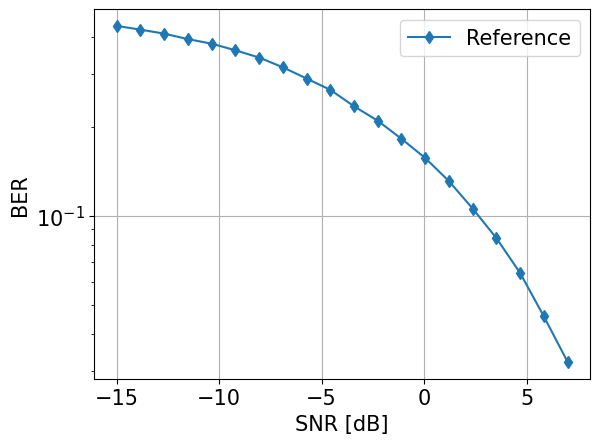

In [18]:
plt.figure()
plt.plot(snr_range, bers[0], 'd-', label = 'Reference')

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend()
plt.show()

In [19]:
# SVD simulations. Single stream
# ---------------------------------------------------------------------------------------
# SNR values we would like to use in modeling
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
print(H.shape)
# How many bit streams we have
N_layers = 1

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
svd_bers = np.zeros((N_layers, len(snr_range)))

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
	for time in range(N_tti):
		Ht = H[..., time]
		bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
		qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

		precoder = get_precoder(H = Ht, rank = N_layers, precoder_type = 'svd')
		X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
		Y_noisy = receiver_signal(Ht, X, snr)
		H_eff_est = effective_channel(Ht, precoder)
		S_est = equalize(Y_noisy, H_eff_est)
		#est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
		est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
		svd_bers[:, snr_idx] +=  bit_error_rate(bits.reshape(N_layers,-1), est_bits)

svd_bers = svd_bers/N_tti
# ---------------------------------------------------------------------------------------

(4, 64, 256, 100)


  0%|          | 0/20 [00:00<?, ?it/s]

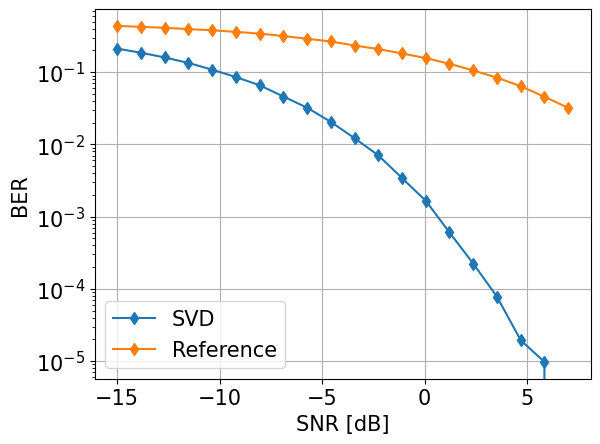

In [20]:
plt.figure()
plt.plot(snr_range, svd_bers[0], 'd-', label = 'SVD')
plt.plot(snr_range, bers[0], 'd-', label = 'Reference')
plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend()
plt.show()

In [21]:
# SVD simulations. Double stream. 50/50 energy spliting
# ---------------------------------------------------------------------------------------
# SNR values we would like to use in modeling
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
print(H.shape)
# How many bit streams we have
N_layers = 2

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
svd_bers_2 = np.zeros((N_layers, len(snr_range)))
print(svd_bers_2.shape)

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
	for time in range(N_tti):
		Ht = H[..., time]
		bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers ,N_subcarriers, N_bits_per_conts_point))
		qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

		precoder = get_precoder(H = Ht, rank = N_layers, precoder_type = 'svd')
		precoder /= sqrt(N_layers)

		X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
		Y_noisy = receiver_signal(Ht, X, snr)
		H_eff_est = effective_channel(Ht, precoder)
		S_est = equalize(Y_noisy, H_eff_est)
		est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)

		svd_bers_2[..., snr_idx] +=  bit_error_rate(bits.reshape(N_layers,-1), est_bits)
		#print(precoder.shape, Y_noisy.shape, H_eff_est.shape, S_est.shape, est_bits.shape, bit_error_rate(bits.reshape(1,-1), est_bits).shape)

svd_bers_2 /= N_tti
# ---------------------------------------------------------------------------------------

(4, 64, 256, 100)
(2, 20)


  0%|          | 0/20 [00:00<?, ?it/s]

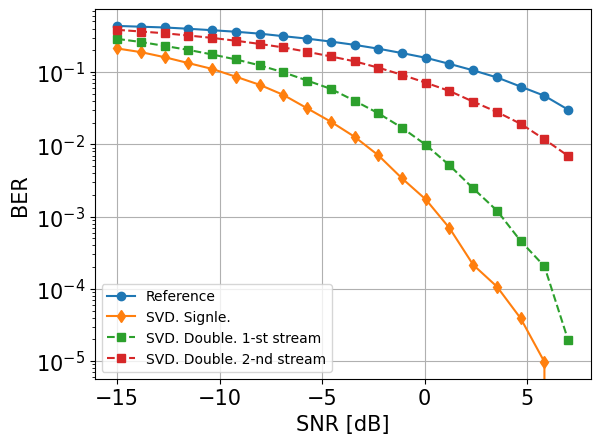

In [22]:
# plot results
plt.figure()
plt.plot(snr_range, bers[0], 'o-', label = 'Reference')
plt.plot(snr_range, svd_bers[0], 'd-', label = 'SVD. Signle.')
plt.plot(snr_range, svd_bers_2[0], 's--', label = 'SVD. Double. 1-st stream')
plt.plot(snr_range, svd_bers_2[1], 's--', label = 'SVD. Double. 2-nd stream')

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend(fontsize = 10)
plt.show()

In [23]:
def compute_antenna_arrays(theta_range, phi_range, m, n):
    m_linspace = np.linspace(0, m - 1, m)
    n_linspace = np.linspace(0, n - 1, n)

    a_theta_plus = np.exp(-2j * np.pi * 0.9 * np.outer(m_linspace, np.sin(theta_range)))
    a_theta_minus = -1j * np.exp(-2j * np.pi * 0.9 * np.outer(m_linspace, np.sin(theta_range)))

    a_phi_plus = np.exp(-2j * np.pi * 0.5 * np.outer(n_linspace, np.sin(phi_range)))
    a_phi_minus = -1j * np.exp(-2j * np.pi * 0.5 * np.outer(n_linspace, np.sin(phi_range)))

    A_plus = np.zeros((m * n, len(theta_range), len(phi_range)), dtype = np.complex128)
    A_minus = np.zeros((m * n, len(theta_range), len(phi_range)), dtype = np.complex128)

    for i in range(len(phi_range)):
        for j in range(len(theta_range)):
            A_plus[:, j, i] = np.outer(a_phi_plus[:, i], a_theta_plus[:, j]).flatten()
            A_minus[:, j, i] = np.outer(a_phi_minus[:, i], a_theta_minus[:, j]).flatten()

    return A_plus, A_minus

In [24]:
def compute_power_spectrum(H, A_plus, A_minus):
    ro = np.zeros((A_plus.shape[1], A_plus.shape[2]))
    N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape

    for n_ue in tqdm(range(N_ue_ants)):
        for subc in range(N_subcarriers):
            H_plus = np.expand_dims(H[n_ue, 0:32, subc, 0], 0)
            H_minus = np.expand_dims(H[n_ue, 32:, subc, 0], 0)

            res1 = np.einsum("ij,jks->iks", np.conj(H_plus), A_plus)
            res2 = np.einsum("ij,jks->iks", np.conj(H_minus), A_plus)

            ro += np.squeeze(np.square(np.abs(res1 + res2)), 0)

    return ro

In [25]:
def spat_spectrum(H, num_beams = None):
    N_ue, N_bs, N_subcar, T = H.shape
    theta_amount, phi_amount = 200, 200
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, theta_amount)
    phi_range = np.linspace(-np.pi / 2, np.pi / 2, phi_amount)
    m, n = 4, 8

    A_plus, A_minus = compute_antenna_arrays(theta_range, phi_range, m, n)

    n_ue_range = np.arange(0, N_ue)
    n_sub_range = np.arange(0, N_subcar)

    ro = compute_power_spectrum(H, A_plus, A_minus)

    ro /= len(n_ue_range)
    ro /= len(n_sub_range)
    ro = np.log(ro + 1e-10)  # to avoid log(0)

    plt.pcolor(90 * theta_range * 2 / np.pi, 90 * phi_range * 2 / np.pi, ro, label = "Power")
    plt.xlabel("Azimuth [deg]")
    plt.ylabel("Elevation [deg]")
    title_str = "Spacial Spectrum" if num_beams == None else f"Spacial Spectrum, Num_beams = {num_beams}"
    plt.title(title_str)
    color = plt.colorbar()
    color.set_label("Power [dB]")
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

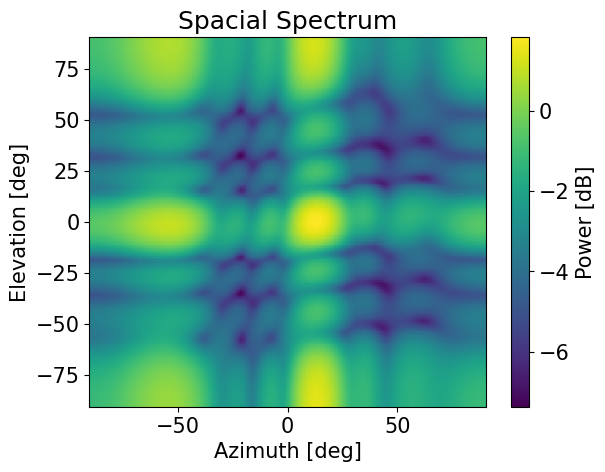

In [26]:
spat_spectrum(H)

In [27]:
def beam_approximation(H_input, N_beams):
    sq_fac = False
    if H_input.ndim == 3:
        H_input = np.expand_dims(H_input, axis = 3)
        sq_fac = True

    N_ue_ants, N_bs_ants, N_subcarriers, N_times = H_input.shape

    approx_H = np.zeros_like(H_input, dtype = np.complex128)
    Fourier_transformed = np.fft.fft(H_input, axis = 1)
    argmaxes = np.argpartition(np.abs(Fourier_transformed), kth = -N_beams, axis = 1)[:, -N_beams:, ...]

    mask = np.ones(Fourier_transformed.shape, dtype = bool)
    for idx in range(N_ue_ants):
        for sub_idx in range(N_subcarriers):
            for time_idx in range(N_times):
                indices = argmaxes[idx, :, sub_idx, time_idx]
                mask[idx, indices, sub_idx, time_idx] = False

    Fourier_transformed[mask] = 0
    approx_H = np.fft.ifft(Fourier_transformed, axis = 1)
    approx_H = normalize(approx_H)

    if sq_fac == True:
        approx_H = np.squeeze(approx_H, 3)

    return approx_H

  0%|          | 0/4 [00:00<?, ?it/s]

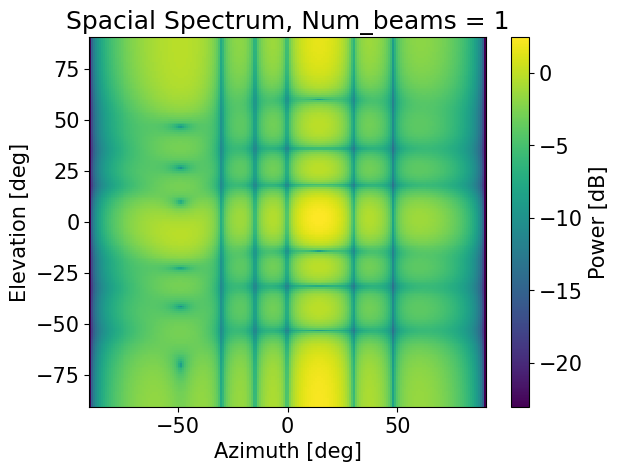

  0%|          | 0/4 [00:00<?, ?it/s]

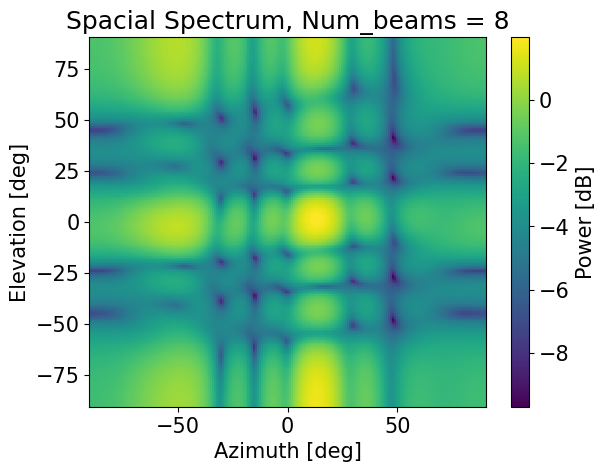

  0%|          | 0/4 [00:00<?, ?it/s]

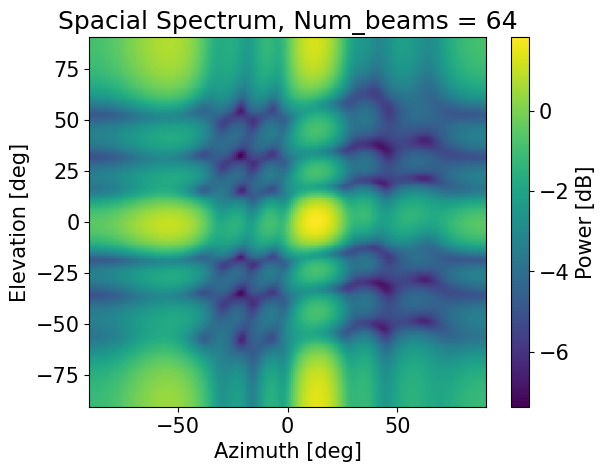

In [28]:
spat_spectrum(beam_approximation(H, 1), 1)
spat_spectrum(beam_approximation(H, 8), 8)
spat_spectrum(beam_approximation(H, 64), 64)

In [29]:
# SVD simulations. 1 beam approx
# ---------------------------------------------------------------------------------------
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
print(H.shape)
# How many bit streams we have
N_layers = 1

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
svd_beam_1 = np.zeros((N_layers, len(snr_range)))
H_prec_arr = beam_approximation(H, 1)

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
  for time in range(N_tti):
    H_prec = H_prec_arr[..., time]
    Ht = H[..., time]
    bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
    qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

    precoder = get_precoder(H = H_prec, rank = N_layers, precoder_type = 'svd')
    X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
    Y_noisy = receiver_signal(Ht, X, snr)
    H_eff_est = effective_channel(Ht, precoder)
    S_est = equalize(Y_noisy, H_eff_est)
		#est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
    est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
    svd_beam_1[:, snr_idx] +=  bit_error_rate(bits.reshape(N_layers,-1), est_bits)

svd_beam_1 = svd_beam_1/N_tti
# ---------------------------------------------------------------------------------------

(4, 64, 256, 100)


  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
# SVD simulations. 8 beam approx
# ---------------------------------------------------------------------------------------
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
print(H.shape)
# How many bit streams we have
N_layers = 1

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
svd_beam_8 = np.zeros((N_layers, len(snr_range)))
H_prec_arr = beam_approximation(H, 8)
# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
  for time in range(N_tti):
    H_prec = H_prec_arr[..., time]
    Ht = H[..., time]
    bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
    qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

    precoder = get_precoder(H = H_prec, rank = N_layers, precoder_type = 'svd')
    X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
    Y_noisy = receiver_signal(Ht, X, snr)
    H_eff_est = effective_channel(Ht, precoder)
    S_est = equalize(Y_noisy, H_eff_est)
		#est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
    est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
    svd_beam_8[:, snr_idx] +=  bit_error_rate(bits.reshape(N_layers,-1), est_bits)

svd_beam_8 = svd_beam_8/N_tti
# ---------------------------------------------------------------------------------------

(4, 64, 256, 100)


  0%|          | 0/20 [00:00<?, ?it/s]

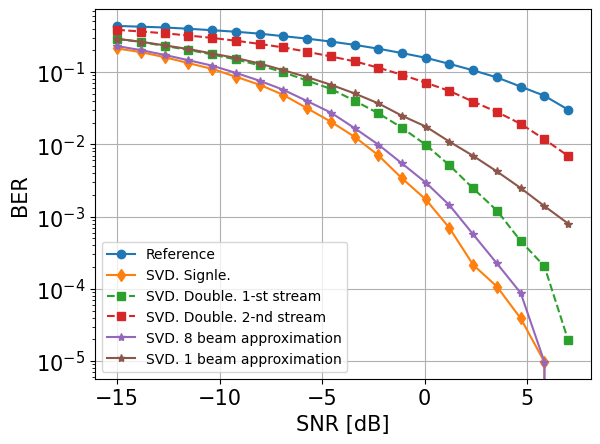

In [31]:
# plot results
plt.figure()
plt.plot(snr_range, bers[0], 'o-', label = 'Reference')
plt.plot(snr_range, svd_bers[0], 'd-', label = 'SVD. Signle.')
plt.plot(snr_range, svd_bers_2[0], 's--', label = 'SVD. Double. 1-st stream')
plt.plot(snr_range, svd_bers_2[1], 's--', label = 'SVD. Double. 2-nd stream')

plt.plot(snr_range, svd_beam_8[0], '*-', label = 'SVD. 8 beam approximation')
plt.plot(snr_range, svd_beam_1[0], '*-', label = 'SVD. 1 beam approximation')

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend(fontsize = 10)
plt.show()

In [32]:
# import some functions that will be used frequenly
from numpy.fft import fft, ifft, fftshift, ifftshift

# subcarrier indices, where SRS pilots are placed
srs_subcarriers = scipy.io.loadmat('srs_sig.mat')['SRS_SC'].flatten()

# SRS signals. Zadoff-Chu sequencies
srs_signal = scipy.io.loadmat('srs_sig.mat')['SRS_SEQ']

print('SRS subc: ', srs_subcarriers.shape)
print('SRS signals: ', srs_signal.shape)

SRS subc:  (288,)
SRS signals:  (8, 288)


In [33]:
# Upload target channel
CHAN_NAME = 'link_chan_{}.mat'.format('2')
H_DL = normalize(scipy.io.loadmat(CHAN_NAME)['Link_Channel'])
H_UL = H_DL.conj().swapaxes(0,1)

# select subcarriers where we have pilots
H_DL = H_DL[:,:,srs_subcarriers,:]
H_UL = H_UL[:,:,srs_subcarriers,:]

target_ue = [1]  # used UE antenna
target_srs = [4] # used SRS signal

interf_ue = [1]  # used UE antenna
interf_srs = [3] # used SRS signal

In [34]:
# Upload interfered channel
CHAN_NAME = 'link_chan_{}.mat'.format('3')
H_DL_interf = normalize(scipy.io.loadmat(CHAN_NAME)['Link_Channel'])
H_UL_interf = H_DL_interf.conj().swapaxes(0,1)

# select subcarriers
H_UL_interf = H_UL_interf[:,:,srs_subcarriers,:]

In [35]:
# fix some time moment
t = 0
H_DL_t = H_DL[..., t]
H_UL_t = H_UL[..., t]

H_UL_t_interf = H_UL_interf[...,0]

print('H_DL_t: ', H_DL_t.shape)
print('H_UL_t: ', H_UL_t.shape)
print('H_UL_t_interf: ', H_UL_t_interf.shape)

H_DL_t:  (4, 64, 288)
H_UL_t:  (64, 4, 288)
H_UL_t_interf:  (64, 4, 288)


In [36]:
# received signal at BS from target user without noise
y_target = receiver_signal(H_UL_t[:,target_ue], srs_signal[target_srs], SNR_dB = None)

# received signal at BS from interfered user without noise
y_interf = receiver_signal(H_UL_t_interf[:,interf_ue], srs_signal[interf_srs], SNR_dB = None)

print('y: ',y_target.shape)

y:  (64, 288)


In [37]:
def correlate_time_domain(x1, x2, normalize = True):
    '''
    Calculates crosscorreltion between two signals in the time domain.
    INPUTS:
        - x1: (np.ndarray) first signal array
        - x2: (np.ndarray) second signal array
        - normalize: (bool). If 'True' then normalize result to have max amplitude equal to 1.
          if 'False' then normalization is not applied
    OUTPUTS:
        - Absolute value of crosscorrelataion between X1 and X2, where X1 and X2
          are inverse Fourier transfrom of x1 and x2 respectively.
    '''

    # Your code here
    # ---------------------------------------------------------------------------------------
    #   IFFT of x1
    x1_ifft = ifft(x1)

    #   IFFT of x2
    x2_ifft = ifft(x2)

    #   crosscorrelation of previous signals
    corr = scipy.signal.correlate(x1_ifft, x2_ifft)
    #   absolute value of crosscorrelation
    abs_corr = np.abs(corr)
    # ---------------------------------------------------------------------------------------


    if normalize:
        abs_corr /= np.max(abs_corr)

    return abs_corr


def get_dft_axis(x):
    '''
    Reorders axis according to DFT, having 0 DFT bin in the middle of input vector
    '''
    assert len(x.shape) == 1 , 'Only vectors are allowed'
    N = len(x)  # number of elements in the input vector

    # if Number of elements is even
    if N % 2 == 0:
        x_axis =  np.arange(start = - N//2, stop = N//2 , step = 1)
    # if Number of elements is odd
    else:
        x_axis = np.arange(start = -(N-1)//2, stop = (N-1)//2 + 1, step = 1)
    return x_axis

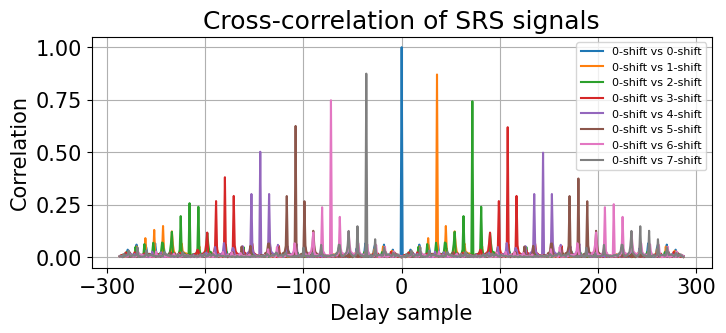

In [38]:
plt.figure(figsize = (8,3))
for i in range(srs_signal.shape[0]):
    c = correlate_time_domain(srs_signal[0], srs_signal[i], normalize = False)
    plt.plot(get_dft_axis(c), c, label = '0-shift vs {0}-shift'.format(i) )
plt.ylabel('Correlation')
plt.xlabel('Delay sample')
plt.title('Cross-correlation of SRS signals')
plt.grid()
plt.legend(fontsize = 8)
plt.show()

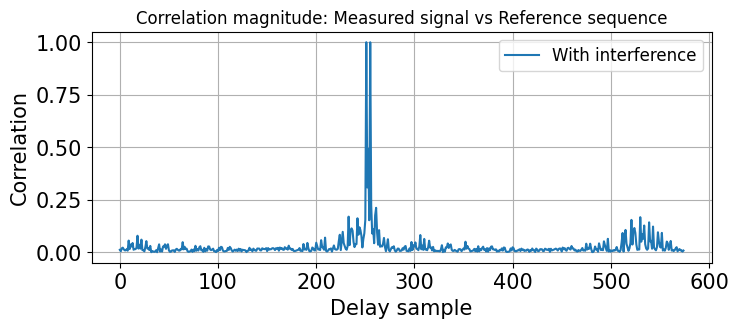

In [39]:
# autocorrelation of SRS for target UE
corr_without_channel = correlate_time_domain(srs_signal[target_srs],
                                             srs_signal[target_srs],
                                             normalize = True)

# cross-correlation for target SRS and received target SRS
corr_with_channel = correlate_time_domain(srs_signal[target_srs][0],
                                          y_target[0], # fixing some BS ant
                                          normalize = True)

# cross-correlation for target SRS and received interfered SRS
corr_interfrence = correlate_time_domain(srs_signal[target_srs][0],
                                         y_interf[0], # fixing some BS ant
                                         normalize = True)

# Plot correlations
plt.figure(figsize = (8,3))
#plt.plot(corr_with_channel, label = 'With channel')
#plt.plot(corr_without_channel, label = 'Without channel')
plt.plot(corr_interfrence, label = 'With interference')
plt.grid()
plt.title('Correlation magnitude: Measured signal vs Reference sequence', fontsize = 12)
plt.legend(fontsize = 12)
plt.ylabel('Correlation')
plt.xlabel('Delay sample')
plt.show()

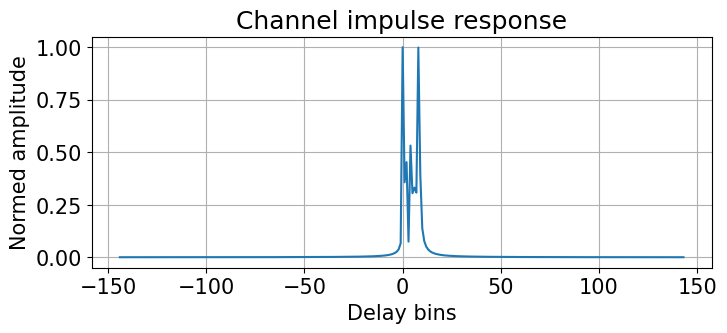

In [40]:
# CIR plotting for fixed pair of antennas
def plot_CIR(x):
    assert len(x.shape) == 1, 'Only vectors are allowed'

    plt.figure(figsize = (8,3))
    cir = fftshift(np.abs(ifft(x)))
    cir_normalized = cir/np.max(cir)
    plt.plot(get_dft_axis(cir_normalized), cir_normalized)
    plt.grid()
    plt.title('Channel impulse response')
    plt.ylabel('Normed amplitude')
    plt.xlabel('Delay bins')
    plt.show()

plot_CIR(H_DL_t[target_ue[0], 0])

In [41]:
def LS_channel_est(y,s):
    '''
    LS channel estimation.
    INPUTS:
        - y: (np.ndarray) received pilot signal with shape of [N_bs_ants x N_subcarriers]
        - x: (np.ndarray) transmitted pilot signal with shape of [N_subcarriers]
    '''

    N_bs, N_subc = y.shape
    h_est = np.zeros((N_bs, 1, N_subc), dtype = np.complex128)

    # ---------------------------------------------------------------------------------------
    y_exp = np.expand_dims(y, 1)
    s_exp= np.expand_dims(s, 0)
    h_est = np.einsum("ijk,jk->ijk", y_exp, np.conj(s_exp))
    # ---------------------------------------------------------------------------------------

    return h_est

In [42]:
H_est_UL = LS_channel_est(y_target, srs_signal[0])
H_est_DL = H_est_UL.swapaxes(0,1).conj()

In [43]:
# Modulation scheme
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))
modem = QAMModem(M = N_constellation_points,
                 bin_input = True,
                 gray_map = True,
                 soft_decision = False,
                 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# Generate bit sequence that will be transmitted to UE
input_bits = np.random.binomial(n = 1, p = 0.5,
                                size = (1, 288, N_bits_per_conts_point))

# Modulated signal
ofdm_symbols = modem.modulate(input_bits.flatten()).reshape(1, 288) / constellation_norm

In [44]:
# calulate precoder
precoder = get_precoder(H_est_DL, 1 ,'svd')
precoder.shape

(64, 1, 288)

In [45]:
# Calculate transmitted signal
X = transmitter_signal(s_signal = ofdm_symbols, precoder = precoder)
X.shape

(64, 288)

In [46]:
# Signal at the receiver side
# We use here physically real DL channel for target user!
Y = receiver_signal(H_DL_t[target_ue], X, None)
Y.shape

(1, 288)

In [47]:
# Ideal channel estimation
H_eff = effective_channel(H_DL_t[target_ue], precoder)

# Equalizer
S_est = equalize(Y, H_eff) * constellation_norm

# estimated bit sequence
bits_est = modem.demodulate(S_est.flatten()).reshape(1, -1)

# obtaining BER
bit_error_rate(bits_est, input_bits.reshape(1, -1))

array([0.])

In [62]:
def channel_experiment(filter, uplink_noise, interference):
    snr_range = np.linspace(-15, 7, 20)
    N_ue, N_bs_ants, N_subcarriers, N_tti = H_DL.shape
    N_layers = 1
    N_constellation_points = 16
    N_bits_per_conts_point = int(np.log2(N_constellation_points))
    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5
    bers = np.zeros((N_layers, len(snr_range)))
    prec = "svd"

    for snr_idx, snr in enumerate(tqdm(snr_range)):
        ber_per_time = np.zeros((N_layers, N_tti))
        for t in range(N_tti):

            # Uplink. SRS
            # ---------------------------------------------------------------------------------------
            # Your code here

            #   slice current tti for target and interfering channels
            target_s = srs_signal[target_srs]
            interf_s = srs_signal[interf_srs]

            #   calculate received signals for target and interference
            # received signal at BS from target user without noise
            #   !!! Add noise ONLY to target received signal !!!
            H_DL_t = H_DL[..., t]
            H_UL_t = H_UL[..., t]
            H_UL_t_interf = H_UL_interf[...,t]
            H_DL_t_interf = H_DL_interf[...,t]

            if uplink_noise:
                snr_uplink = snr
            else:
                snr_uplink = None
            y_target = receiver_signal(H_UL_t[:,target_ue], target_s, SNR_dB = snr_uplink)

            # received signal at BS from interfered user without noise
            if interference:
                y_interf = receiver_signal(H_UL_t_interf[:,interf_ue], interf_s, SNR_dB = None)
            else:
                y_interf = np.zeros(y_target.shape, dtype=np.complex128)

            # sum receved signals for target and interference (if required)
            y_sum = y_target + y_interf

            #   Obtain UL and then DL channel estimation

            #   Apply filter (if required) for DL estimated channel
            H_est_UL = LS_channel_est(y_sum, srs_signal[0])
            H_est_DL = H_est_UL.swapaxes(0,1).conj()

            if filter is not None:
                H_est_DL = window_filter(H_est_DL, filter)

            # Downlink. Data transmission.
            # ---------------------------------------------------------------------------------------
            #   ...Same actions as in 1-st part of the homework...
            #   !!! Estimated DL channel used only for precoder calculation !!!
            #   !!! Use ideal channel estimation for DL equalizer !!!
            # ---------------------------------------------------------------------------------------

            bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))

            # Create 1 OFDM symbol with N_subcarriers QAM symbols.
            qam_symbols = modem.modulate(bits.flatten()).reshape((N_layers, N_subcarriers)) / constellation_norm
            precoder = get_precoder(H = H_est_DL, rank = N_layers, precoder_type = prec)
            X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)

            # Obtain signal with noise
            Y_noisy = receiver_signal(H_DL_t[target_ue], X, snr)

            H_eff_est = effective_channel(H_DL_t[target_ue], precoder)
            S_est = equalize(Y_noisy, H_eff_est)

            est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
            res = bit_error_rate(bits.reshape(N_layers,-1), est_bits)
            bers[:, snr_idx] += res

    bers /= N_tti

    return bers

In [49]:
ber_ideal = channel_experiment(None, False, False)
ber_noisy = channel_experiment(None, True, False)
ber_interf = channel_experiment(None, False, True)
ber_interf_noise = channel_experiment(None, True, True)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

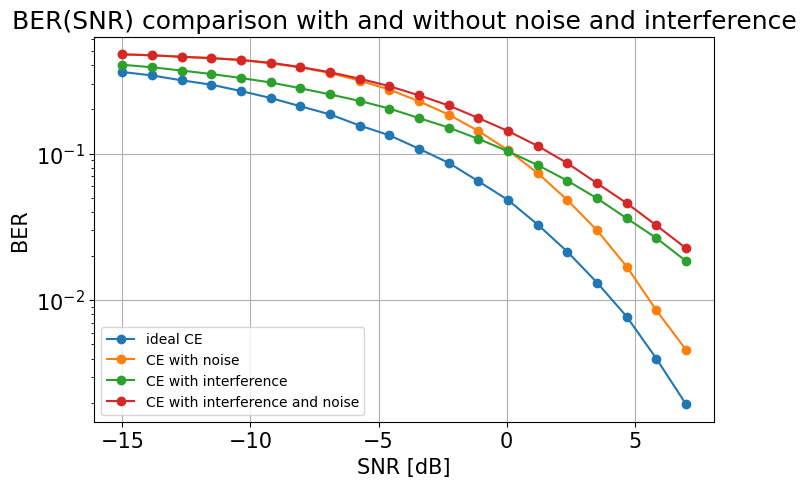

In [50]:
# plot results (example)
plt.figure(figsize = (8,5))
plt.plot(snr_range, ber_ideal[0], 'o-', label = 'ideal CE')
plt.plot(snr_range, ber_noisy[0], 'o-', label = 'CE with noise')
plt.plot(snr_range, ber_interf[0], 'o-', label = 'CE with interference')
plt.plot(snr_range, ber_interf_noise[0], 'o-', label = 'CE with interference and noise')


plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.title("BER(SNR) comparison with and without noise and interference")
plt.legend(fontsize = 10, loc = 'lower left')
plt.show()

In [51]:
def mean_CIR(x):
    '''
    Calculates CIR meaned along antennas
    INPUTS:
        - x: (np.ndarray) chanel with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
    OUTPUTS:
        - 1d CIR with shape of N_subcarriers, meaned along N_ue_ants and N_bs_ants
    '''

    X = ifft(x, axis = -1, norm = 'ortho') # Transfrom from frequency domain into time domain
    X = ifftshift(X, axes = -1)            # Move zero bin into the middle
    X_abs = np.abs(X)                      # Amplitude of delay spectrum
    X_mean = np.mean(X_abs, (0,1))         # Mean Amplitude along antenna space
    return X_mean


### Let us compare ideal and noisy channels
# obtain CE without noise
y_target = receiver_signal(H_UL_t[:,target_ue],
                           srs_signal[target_srs],
                           SNR_dB = None)
H_est_UL = LS_channel_est(y_target, srs_signal[target_srs].flatten())
H_est_DL_ideal = H_est_UL.swapaxes(0,1).conj()  # Ideal DL channel estimation


# obtain CE with noise
y_target = receiver_signal(H_UL_t[:,target_ue],
                           srs_signal[target_srs],
                           SNR_dB = -10)
H_est_UL = LS_channel_est(y_target, srs_signal[target_srs].flatten())
H_est_DL_noisy = H_est_UL.swapaxes(0,1).conj()  # Noisy DL channel estimation


# obtain CE of interfered channel without noise
y_interf = receiver_signal(H_UL_t_interf[:,interf_ue],
                           srs_signal[interf_srs],
                           SNR_dB = None)

H_est_UL = LS_channel_est(y_target + y_interf, srs_signal[target_srs].flatten())
H_est_DL_noisy_interf = H_est_UL.swapaxes(0,1).conj()

# calcuate CIRs meaned over antenna space
cir_ideal = mean_CIR(H_est_DL_ideal)
cir_noisy = mean_CIR(H_est_DL_noisy)
cir_noisy_interf = mean_CIR(H_est_DL_noisy_interf)

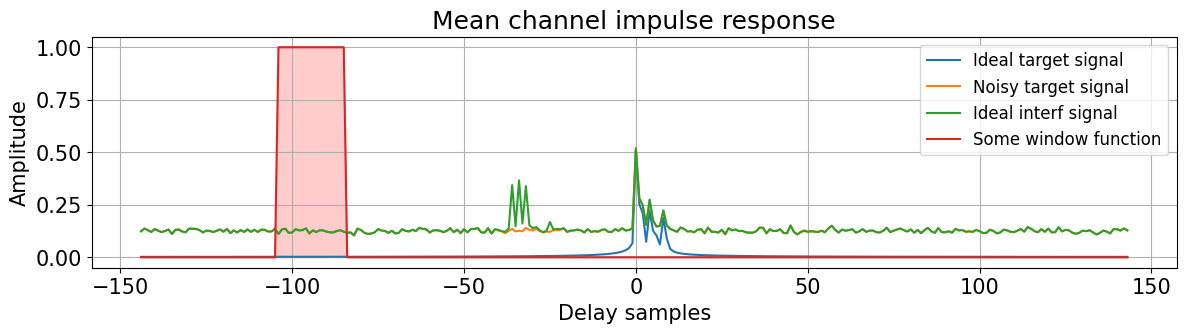

In [52]:
plt.figure(figsize=(14,3))
plt.plot(get_dft_axis(cir_ideal), cir_ideal, label = 'Ideal target signal')
plt.plot(get_dft_axis(cir_noisy), cir_noisy, label = 'Noisy target signal')
plt.plot(get_dft_axis(cir_noisy_interf), cir_noisy_interf, label = 'Ideal interf signal')
wind_example = np.zeros_like(cir_ideal)
wind_example[40:60] = 1
plt.plot(get_dft_axis(wind_example), wind_example, label = 'Some window function')
plt.fill_between(get_dft_axis(wind_example), wind_example, 0, color='red', alpha =0.2)

plt.title('Mean channel impulse response')
plt.xlabel('Delay samples')
plt.ylabel('Amplitude')
plt.grid()
plt.legend(fontsize = 12)
plt.show()

In [53]:
def window_filter(H_est, window):
    '''
    Applies window filter in the delay domain
    INPUTS:
        - H_est: (np.ndarray) estimated DL channel with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
        - window: (Any) paramenters of the window which you would like to define
    '''
    N_ue, N_bs_ants, N_delays = H_est.shape

    # Your code here
    # ---------------------------------------------------------------------------------------
    #   Transfrom signal from frequency domain into delay domain
    h_imp = ifft(H_est, axis = -1)
    #   Calculate and apply window filter
    h_imp = np.multiply(h_imp, window)
    #   Transform back from delay domain into frequency domain
    H_filtered = fft(h_imp)
    # ---------------------------------------------------------------------------------------

    return H_filtered

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

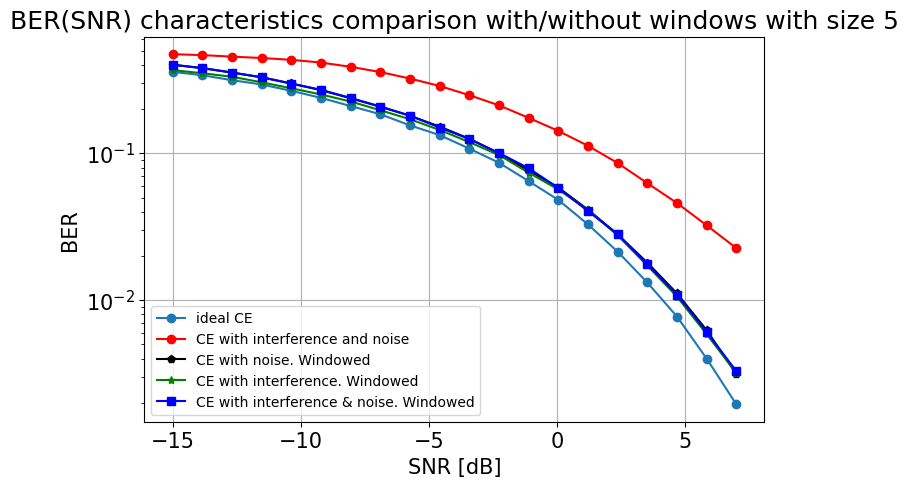

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

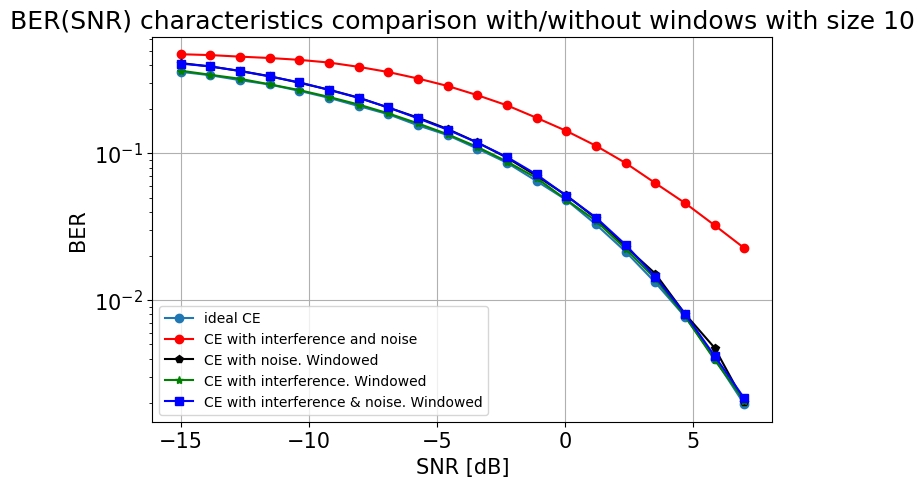

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

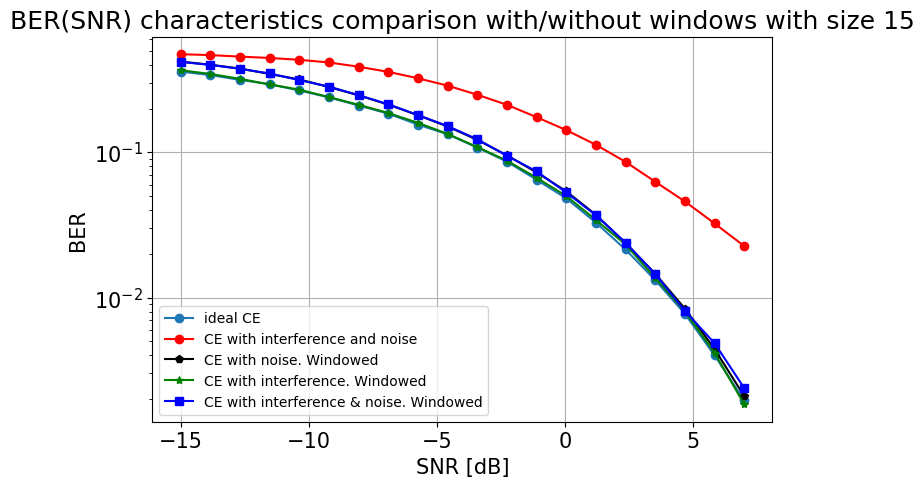

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

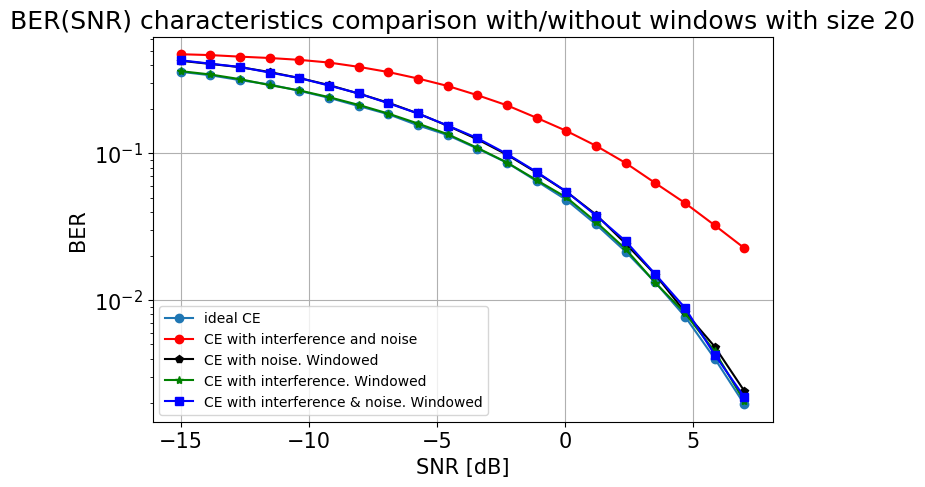

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

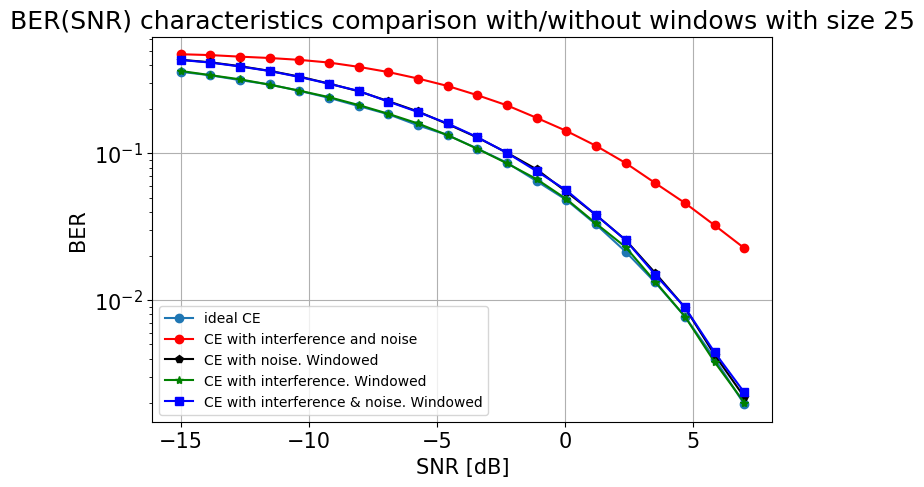

In [63]:
# Предполагается, что srs_subcarriers и snr_range уже определены

for window_size in range(5, 30, 5):
    window = np.zeros(srs_subcarriers.shape)
    window_start = int(srs_subcarriers.shape[0] / 2)
    window[window_start:window_start + window_size] = 1

    # Подготовка аргументов
    arguments = [
        (window, True, False),
        (window, False, True),
        (window, True, True)
    ]

    # Выполнение экспериментов последовательно
    ber_noisy_window = channel_experiment(arguments[0][0],arguments[0][1], arguments[0][2])
    ber_interf_window = channel_experiment(*arguments[1])
    ber_interf_noise_window = channel_experiment(*arguments[2])

    # Визуализация результатов
    plt.figure(figsize=(8, 5))
    plt.plot(snr_range, ber_ideal[0], 'o-', label='ideal CE')
    plt.plot(snr_range, ber_interf_noise[0], 'o-', label='CE with interference and noise', color='red')
    plt.plot(snr_range, ber_noisy_window[0], 'p-', color='black', label='CE with noise. Windowed')
    plt.plot(snr_range, ber_interf_window[0], '*-', color='green', label='CE with interference. Windowed')
    plt.plot(snr_range, ber_interf_noise_window[0], 's-', color='blue', label='CE with interference & noise. Windowed')

    plt.yscale('log')
    plt.grid()
    plt.xlabel('SNR [dB]')
    plt.ylabel('BER')
    plt.title(f'BER(SNR) characteristics comparison with/without windows with size {window_size}')
    plt.legend(fontsize=10, loc='lower left')
    plt.show()